In [1]:
import anndata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
from sklearn.decomposition import PCA

ad_atac = anndata.read_h5ad('/home/yuanh/sc_basset/datasets/10x_ARC_mouse_brain/ad_atac.h5ad')
ad_rna = anndata.read_h5ad('/home/yuanh/sc_basset/datasets/10x_ARC_mouse_brain/scvi/ad_rna_scvi.h5ad')
ad_atac.obs['leiden_rna'] = ad_rna.obs['leiden'].values

# compute label score and neighbor score
def compute_metric(ad_rna, ad_atac, nn, label_obs_idx=1):
    # RNA neighbors
    sc.pp.neighbors(ad_rna, n_neighbors=nn+1, use_rep='scvi')
    m_RNA_neighbors = [i.indices for i in ad_rna.obsp['distances']] # neighbor idx for each cell
        
    # ATAC neighbors
    sc.pp.neighbors(ad_atac, n_neighbors=nn+1, use_rep='projection') # n nearest neighbor of each cell
    m_ATAC_neighbors = [i.indices for i in ad_atac.obsp['distances']] # neighbor idx for each cell

    # neighbor score
    n_shared_neighbors = np.mean([len(np.intersect1d(i,j)) for i,j in zip(m_RNA_neighbors, m_ATAC_neighbors)])

    # label score
    neighbor_label = ad_atac.obs.iloc[np.concatenate(m_ATAC_neighbors, axis=0), label_obs_idx] # label for all neighbors
    cell_label = ad_atac.obs.iloc[np.repeat(np.arange(len(m_ATAC_neighbors)), [len(j) for j in m_ATAC_neighbors]), label_obs_idx] # label for all cells
    n_shared_labels = (neighbor_label.values==cell_label.values).sum() / len(m_ATAC_neighbors)

    return n_shared_neighbors/nn, n_shared_labels/nn


In [2]:
n_topics = [2, 5, 10, 20, 30, 40, 50, 60, 80, 100]
out = pd.DataFrame(np.nan, index=n_topics, columns=['scores'])

for i in n_topics:
    embed = pd.read_csv('models/topics_%d.csv'%i, index_col=0).values
    ad_atac.obsm['projection'] = embed
    neighbor_score, label_score = compute_metric(ad_rna, ad_atac, 100)
    out.loc[i, 'scores'] = neighbor_score
    
out.to_csv('eval.csv')

In [3]:
out

,scores
2,0.078371
5,0.209814
10,0.245513
20,0.300631
30,0.308906
40,0.314011
50,0.318422
60,0.320553
80,0.319453
100,0.318461


### plot

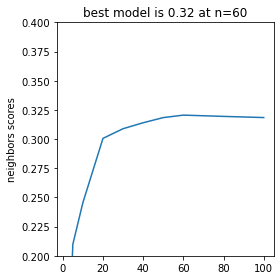

In [4]:
toplot = out.copy()
f, ax = plt.subplots(figsize=(4, 4))
toplot['scores'].plot.line(ax=ax)

best_n = n_topics[toplot['scores'].argmax()]
best_val = toplot['scores'].max()
ax.set_ylabel('neighbors scores')
ax.set_title('best model is %.2f at n=%d'%(best_val, best_n))
ax.set_ylim(0.2, 0.4)

f.tight_layout()
f.savefig('eval.pdf')

### save

In [5]:
i = 60
embed = pd.read_csv('models/topics_%d.csv'%i, index_col=0).values
pd.DataFrame(embed).to_csv('projection.csv')